In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import wave
import pylab
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras import layers, models, Model
import tensorflow as tf
from pydub import AudioSegment
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from audiomentations import Compose, TimeMask, SpecFrequencyMask, PitchShift, AddGaussianNoise

## SPLIT AUDIO

In [2]:
full_audio_directory = '../raw_data/full_podcast' # full audio can be found here
episode_directory = '../raw_data/5_sec_clips/99percentinvisible/' # where new clips will be stored
input_podcast_name = 'infernal_machine'
output_podcast_name = 'planet_money'
wav_clips_directory = '../raw_data/5_sec_clips/99percentinvisible/infernal_machine'
images_directory = '../raw_data/5_sec_clips/99percentinvisible/infernal_machine_images'

In [3]:
def split_files(original_file, ad_list, podcast_name, episode_directory, run_env="local"):

    """
    This function takes an original audio file name, list of integers showing
    when each ad starts and ends and a podcast name and splits up the original
    file into 5 second chunks, naming each one according to whether it contains
    ads or not.
    """

    # Create a folder for the podcast and their clips:
    podcast_folder = os.path.join(episode_directory, podcast_name)

    if run_env == "local":
        #Check if the folder already exists and has any .mp3 files
        if os.path.exists(podcast_folder) and any(fname.endswith('.wav') for fname in os.listdir(podcast_folder)):
            print(f"Skipping {podcast_name} because it has already been processed.")
            return 'skipped'

        # Create the directory if doesnt exist:
        if not os.path.exists(podcast_name):
            os.makedirs(podcast_folder)
            print(f"Created folder: {podcast_folder}")


    # Determine the file extension and load the audio file accordingly
    file_extension = os.path.splitext(original_file)[1].lower()

    if file_extension == '.mp3':
        new_audio = AudioSegment.from_mp3(original_file)
    elif file_extension == '.wav':
        new_audio = AudioSegment.from_wav(original_file)
    else:
        raise ValueError(f"Unsupported file format: {file_extension}. Only .mp3 and .wav are supported.")

    # Save duration
    duration = int(new_audio.duration_seconds)

    # Set default to no_ad
    is_ad = '0'

    # If the ad_list doesn't start with 0, then the ads don't start straight away.
    # in this case, insert '0' first in the list so that a segment is created at the start.
    if ad_list[0] != 0:
        ad_list.insert(0, 0)
        is_ad = '1'

    # Add duration at the end so that the end segments can be made.
    if ad_list[-1] != duration:
        ad_list.append(duration)

    #Go through each segement in the list, label whether the section is an ad or not
    for index in range(0,len(ad_list)-1):
        start = ad_list[index]
        end = ad_list[index+1]
        # Toggle between 'ad' and 'no_ad'
        if is_ad == '1':
            is_ad = '0'
        else:
            is_ad = '1'

        # Go through each second in the segment and create a new 5 second clip from here.
        # Stop before the end of the segment so that only 5 second clips are created
        for tc in range(start, (end-4)):
            start_clip = tc*1000 #pydub works with milliseconds, so seconds are converted here
            end_clip = (tc+5)*1000

            # Construct the file path for saving
            output_file = os.path.join(podcast_folder, f'{is_ad}_{tc}_{duration}_{podcast_name}.wav')

            if run_env == "local":
                # Save clip locally:
                new_audio[start_clip:end_clip].export(output_file, format='wav')
                print(f"Saved clip: {output_file}")


    is_ad = '0'
    return 'finished'

In [ ]:
podcast_files_mp3_wav = [
  (os.path.join(full_audio_directory, "infernal_machine.mp3"), [0,50, ((15*60)+50), ((16*60)+21),((30*60)+18), ((30*60)+49)], "infernal_machine"),
]

# Loop through each file and split into 5 sec chunks
for file_name, ad_list, podcast_name in podcast_files_mp3_wav:
    result = split_files(file_name, ad_list, podcast_name, episode_directory)
    print(f'Processing {podcast_name}: {result}')

Created folder: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_0_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_1_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_2_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_3_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_4_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_5_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_6_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_7_1848_infernal_machine.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/infernal_machine/1_8_1848_infernal_machine.wav
Saved 

# DATA PREPARATION:

In [4]:
# Utility function to get sound and frame rate info
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

Processing files: total 1829


/Users/jenni/.pyenv/versions/3.10.6/envs/podcast-ad-skipper/lib/python3.10/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


KeyboardInterrupt: 

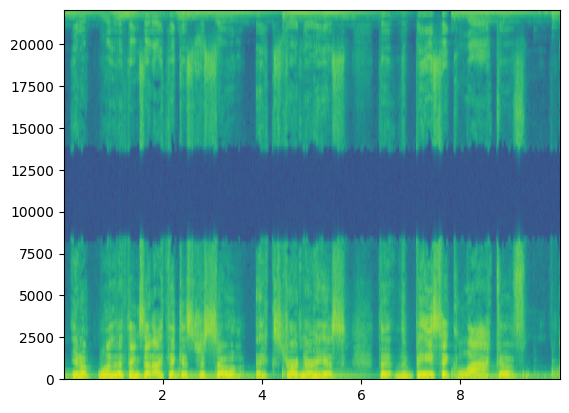

In [ ]:
# Iterate over all files in the directory
file_list = os.listdir(wav_clips_directory)
print(f"Processing files: total {len(file_list)}")

for filename in file_list:
    # Create spectrogram and convert to image
    sound_info, frame_rate = get_wav_info(os.path.join(wav_clips_directory,filename))
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig(f'{images_directory}/{filename}.png')
    pylab.close()


In [5]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 57
N_CHANNELS = 3
N_CLASSES = 1

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_directory,
    labels='inferred',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    # shuffle=True,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset="training",
    seed=0)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    images_directory,
    labels='inferred',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    # shuffle=True,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset="validation",
    seed=0)

Found 1829 files belonging to 2 classes.
Using 1464 files for training.
Found 1829 files belonging to 2 classes.
Using 365 files for validation.


2024-10-31 18:03:14.776037: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


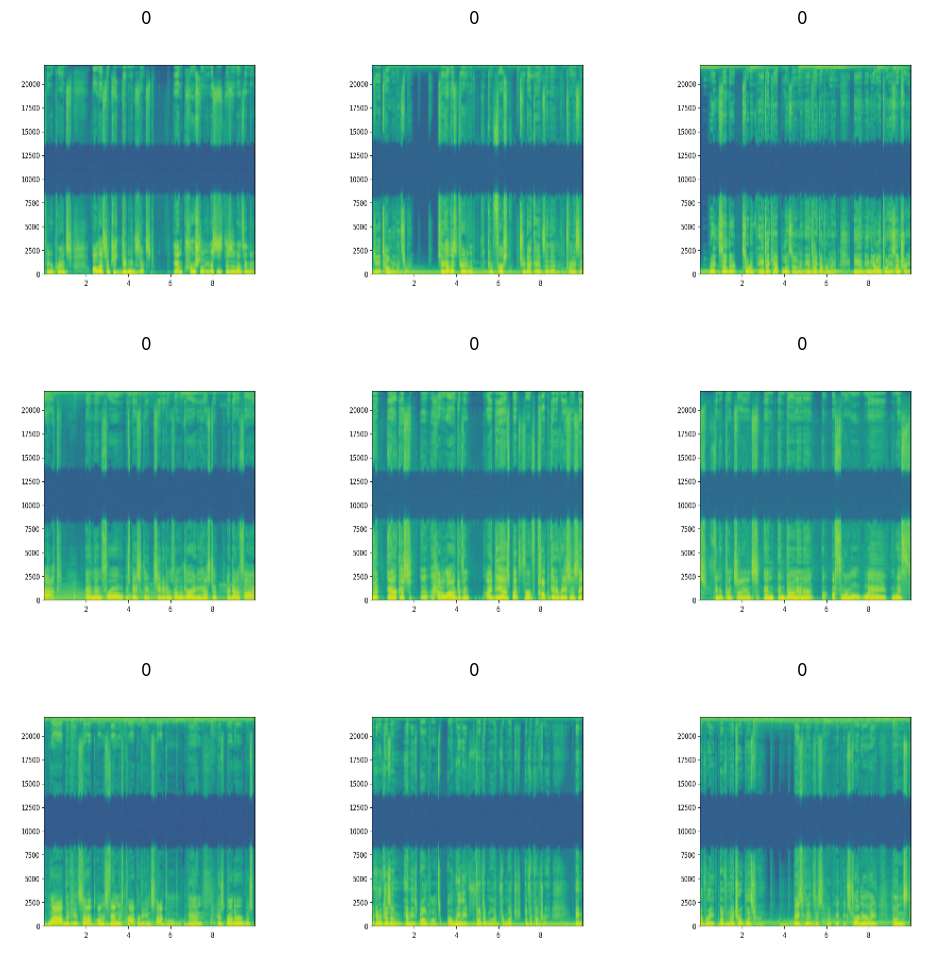

In [7]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [8]:
def prepare(ds, augment=True):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.Rescaling(1./256)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2)
    ])

    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

# MODEL

In [9]:
def build_baseline_model(input_shape=(256,256,3), freeze_base=True):
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        input_shape=input_shape,
        weights=None)
    base_model.trainable = freeze_base
    x = base_model.output

    #flatten
    x = layers.Flatten()(x)

    #dense layer for ad detection
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #output layer for ad detection
    output = layers.Dense(1, activation='sigmoid')(x)
    loss = 'binary_crossentropy'

    #create
    model = models.Model(
        inputs=base_model.input,
        outputs=output
    )

    #compile
    model.compile(
        loss=loss,
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [10]:
model = build_baseline_model(
    input_shape=(256, 256, 3),
    freeze_base=True
)

In [95]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
# model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
# # model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# # model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
# # model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# # model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
# # model.add(tf.keras.layers.BatchNormalization())
# # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# # model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# # model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset, callbacks=[early_stopping,])

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 803s 31s/step - accuracy: 0.9324 - loss: 1.2376 - val_accuracy: 0.9452 - val_loss: 0.2192
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 864s 33s/step - accuracy: 0.9391 - loss: 0.2467 - val_accuracy: 0.9452 - val_loss: 0.2126
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 928s 36s/step - accuracy: 0.9415 - loss: 0.2274 - val_accuracy: 0.9452 - val_loss: 0.2202
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 911s 35s/step - accuracy: 0.9474 - loss: 0.2090 - val_accuracy: 0.9452 - val_loss: 0.2229
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 945s 36s/step - accuracy: 0.9461 - loss: 0.2217 - val_accuracy: 0.9452 - val_loss: 0.2239


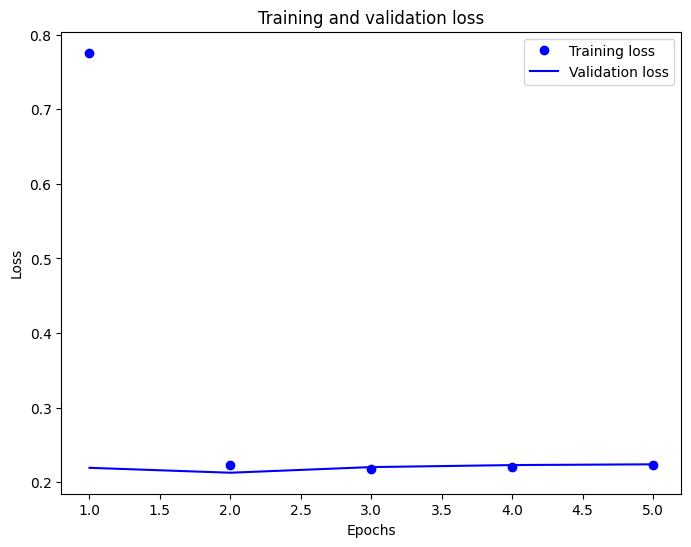

In [96]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

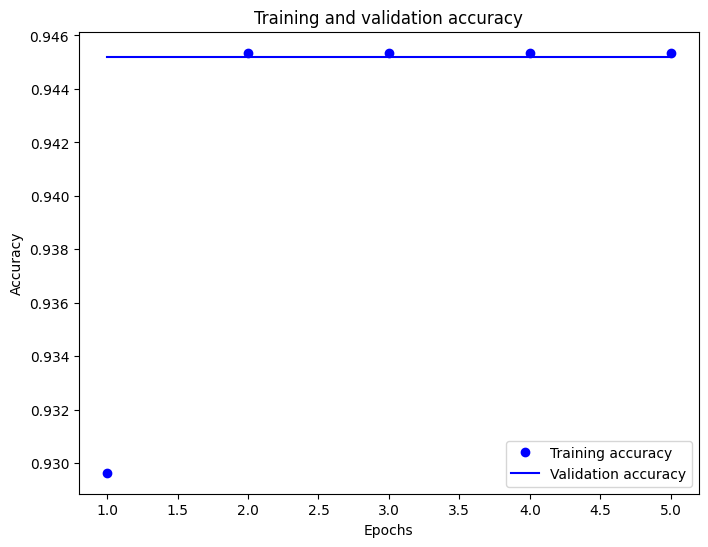

In [97]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [98]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.212650, final accuracy: 0.945205


# NEW FILE & OUTPUT FILE:

In [77]:
predict_podcast = '../raw_data/full_podcast/world_out.mp3'
# Load the podcast file
podcast = AudioSegment.from_file(predict_podcast) # Load the new podcast file
podcast_duration = int(podcast.duration_seconds)
podcast_duration

python(88745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(88747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


2107

In [ ]:
podcast_files_mp3_wav = [
  (os.path.join(full_audio_directory, "world_out.mp3"), [0,30, ((14*60)+16), ((14*60)+48), ((34*60)+36), ((35*60)+8)], "world_out"),
]

# Loop through each file and split into 5 sec chunks
for file_name, ad_list, podcast_name in podcast_files_mp3_wav:
    result = split_files(file_name, ad_list, podcast_name, episode_directory)
    print(f'Processing {podcast_name}: {result}')

Created folder: ../raw_data/5_sec_clips/99percentinvisible/world_out
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_0_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_1_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_2_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_3_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_4_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_5_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_6_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_7_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_8_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisible/world_out/1_9_2107_world_out.wav
Saved clip: ../raw_data/5_sec_clips/99percentinvisi

In [ ]:
# directory = '../raw_data/5_sec_clips/99percentinvisible/world_out'

# for file in os.listdir(directory)[:10]:
#     sound_info, frame_rate = get_wav_info(os.path.join(directory,file))
#     pylab.specgram(sound_info, Fs=frame_rate)
#     pylab.savefig(f'../raw_data/5_sec_clips/99percentinvisible/planetmoney_images/{file}.png')
#     pylab.close()

In [65]:
directory = '../raw_data/5_sec_clips/99percentinvisible/world_out'
for item in os.listdir(directory):
    sound_info, frame_rate = get_wav_info(os.path.join(directory,item))
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig(f'../raw_data/5_sec_clips/99percentinvisible/images/{item}.png')
    pylab.close()

/Users/jenni/.pyenv/versions/3.10.6/envs/podcast-ad-skipper/lib/python3.10/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [99]:
predict_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../raw_data/5_sec_clips/99percentinvisible/images',
    batch_size=2107,
    labels=None,
    shuffle=True,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
    )
predict_ds

Found 2089 files.


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [100]:
rescale = tf.keras.Sequential([tf.keras.layers.Rescaling(1./256)])

# Apply rescale to both datasets and augmentation only to training
predict_ds = predict_ds.map(lambda x: (rescale(x)))

In [ ]:
prediction = model.predict(predict_ds) # Use the model to predict
prediction

In [84]:
prediction[1489]

array([0.01008256], dtype=float32)

In [ ]:
# List to hold the ad segments
ad_segments = []
clip_duration = 5

# Process the podcast in chunks of clip_duration seconds
for i in range(0, podcast_duration):
    start_time = i * 1000  # Convert to milliseconds
    end_time = (i + clip_duration) * 1000

    # Extract the clip from the podcast
    clip = podcast[start_time:end_time]

    # Save the clip as a temporary wav file (for librosa to process)
    clip_file = "temp_clip.wav"
    clip.export(clip_file, format="wav")

    #create spectrogram
    sound_info, frame_rate = get_wav_info(clip_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig(f'../raw_data/5_sec_clips/99percentinvisible/images_test_set2/temp.png')
    pylab.close()
    #add code to delete this later
    predict_ds = tf.keras.preprocessing.image_dataset_from_directory(
        '../raw_data/5_sec_clips/99percentinvisible/images_test_set2',
        batch_size=1,
        shuffle=True,
        color_mode='rgb',
        image_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
        )

    prediction = model.predict(predict_ds) # Use the model to predict

    # If the model predicts 'ad' it will mark this segment as an ad (1)
    if prediction == 1:
        ad_segments.append((i, i + clip_duration))

    # Clean up the temporary file
    os.remove(clip_file)


Found 0 files belonging to 0 classes.


ValueError: No images found in directory ../raw_data/5_sec_clips/99percentinvisible/images_test_set2. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [78]:
def remove_ads_from_podcast(podcast_file, ad_segments):
    """
    Removes the ad segments from the podcast and returns an ad-free podcast.
    podcast_file: Path to the podcast audio file
    ad_segments: List of tuples with (start_time, end_time) of ads in seconds
    return: An AudioSegment object, the podcast without ads
    """
    podcast = AudioSegment.from_file(podcast_file) # Load the podcast file
    podcast_duration = len(podcast)

    clean_podcast = AudioSegment.empty() # Create an empty AudioSegment object
    current_time = 0

    for ad_start, ad_end in ad_segments:
        ad_start_ms = ad_start * 1000 # Convert to milliseconds
        ad_end_ms = ad_end * 1000

        clean_podcast += podcast[current_time:ad_start_ms] # Add the non-ad segment to the clean podcast
        current_time = ad_end_ms  # Update the current time

    clean_podcast += podcast[current_time:podcast_duration]  # Add the last segment of the podcast

    return clean_podcast

In [79]:
# Example of using the functions:
podcast_file = "../raw_data/full_podcast/spirithalloween.mp3" # Path to the new podcast file
ad_segments = detect_ads(podcast_file, model)  # Use trained model here
clean_podcast = remove_ads_from_podcast(podcast_file, ad_segments)

# Saving the ad-free podcast:
clean_podcast.export('podcast_without_ads3.mp3', format='mp3')

Error: file does not start with RIFF id

In [1]:
model.save('model.h5')

NameError: name 'model' is not defined